## Barren Plateaus and how to handle them

In [1]:
import qiskit as qk
from qiskit import Aer, QuantumCircuit

from qiskit.circuit import Parameter, ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigen_solvers.vqe import VQEResult
from qiskit.algorithms.optimizers import COBYLA
from typing import Tuple, List, Dict, Union
from scipy.optimize import minimize, OptimizeResult
import numpy as np
from random import random
import json
from pprint import pprint
import matplotlib.pyplot as plt
from operator import truediv
from cmath import pi
from random import randint
import os
import time
%matplotlib inline

MUB_CIRC_2_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '2_302')
MUB_CIRC_3_PATH = os.path.join(os.getcwd(), 'mub_bqskit', '3_306')

N_QUBIT_NO_MUB_PATH = 'no_mub_results_n.txt'
NO_MUB_PATH = 'no_mub_results_3.txt'
PRE_MUB_PATH = 'prepend_mub_results_3.txt'
K_PRE_MUB_PATH = 'prepend_k_mub_results_3.txt'
RANDOM_THETAS_PATH_3 = 'random_thetas_results_3.txt'

NO_MUB_GRAPH_FOLDER = '3 qubit graphs'
N_QUBIT_NO_MUB_GRAPH_FOLDER = 'n qubit graphs'

VQC_FOLDER = 'VQC results'

EPS_TOL = 1e-12
LO_TOL = 1e-5
HI_TOL = 0.2
LO_CORR_THRESHOLD = 0.1
HI_CORR_THRESHOLD = 0.4
N_QUBITS = 3

SHOTS = 8192
MAX_ITER = 1e8
qasm_backend = Aer.get_backend('qasm_simulator')
qasm_qi = QuantumInstance(qasm_backend, shots=SHOTS)

### Basic Barren Plateau Circuit for Variational Quantum Compilation

The "Cerezo" ansatz circuit is taken from "Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits" by Cerezo et al., 2021, Figure 4.
The "Arrasmith" ansatz circuit is taken from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

The attempted task is "trivial" Variational Quantum Compilation.
Vartational Quantum Compilation gets some unitary $U$, and an ansatz $V(\theta)$, and attempts to find a value for $\theta$ such that $V(\theta)| 0 \rangle = U | 0 \rangle$.

In this case, we choose $U=I$.
Because we pick a *random* initial guess for $\theta$, we will experience the barren plateaus that occur when the $\theta$ values are away from the target.

Note, however, an important observation:
In order to actually use the "value" of the different MUB starting points, the original value of the parameters needs to be constant (although random) for all experiments.

I took this specific problem from "Effect of barren plateaus on gradient-free optimization" by Arrasmith et al. (2021).

In [2]:
def gen_vqc_ansatz_cerezo(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, N_QUBITS):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    qc.measure_all()

    return qc


def gen_vqc_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


## Replicating the BPs - no MUBs

#### Experiment Functions

In [23]:
def low_constraint(x: List[float]):
    return min(x)

def hi_constraint(x: List[float]):
    return 2*pi-max(x)

def get_constraints() -> List[dict]:
    return [{'type': 'ineq', 'fun': low_constraint}, {'type': 'ineq', 'fun': hi_constraint}]

def rand_angle():
    return (np.random.random()) * 2 * pi - pi

# Returns the number of function evaluations it took for the method to converge.
# If during the optimization, the cost function goes below a specified bound, the optimization halts.
# If the optimization halted because of the bound, the OptimizeResult is replaced with None.
def run_vqc_exp(qc: QuantumCircuit, theta0: List[float], tol: float = HI_TOL, success_bound: float=0,
                optimizer: str = 'COBYLA', qi: QuantumInstance = qasm_qi) -> Tuple[List[float], OptimizeResult]:
    class BoundHitException(Exception):
        pass
    
    cost_points = []
    cost_grad = []
    def get_val_from_theta(theta: List[float]) -> float:
        cost_grad.append(theta)
        if float('inf') in theta or float('-inf') in theta:
            print(f'inf bug reached in iteration {len(cost_grad)}.')
            print('printing 99 last cost points:')
            print(cost_points[-99:])
            print('printing 100 last gradient values:')
            print(cost_grad[-100:])
            raise ZeroDivisionError()
        # if len(cost_points) % 100 == 0 or min(theta) < -0.5 or max(theta) > 2*pi:
        #     print(f'{len(cost_points)}: {theta}')
        concrete_qc = qc.bind_parameters(theta)
        results = qi.execute(concrete_qc)
        resval = 1 - (results.get_counts().int_raw.get(0, 0) / SHOTS)
        cost_points.append(resval)
        if (resval) <= success_bound:
            print('WOOP')
            raise BoundHitException()
        return resval

    try:
        if optimizer == 'COBYLA':
            res = minimize(get_val_from_theta,
                theta0,
                method='COBYLA',
                options={'maxiter': MAX_ITER},
                tol=tol,
                constraints=get_constraints())
        elif optimizer == 'Nelder-Mead':
            res = minimize(get_val_from_theta,
                theta0,
                method='Nelder-Mead',
                options={'maxiter': MAX_ITER},
                tol=tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        elif optimizer == 'SLSQP':
            res = minimize(get_val_from_theta,
                theta0,
                method='SLSQP',
                options={'maxiter': MAX_ITER},
                tol=tol,
                bounds = [(-pi,pi) for _ in range(len(theta0))])
        else:
            assert 0==1
        
    except BoundHitException:
        return cost_points, True
    except ZeroDivisionError:
        return cost_points, cost_grad
    except KeyboardInterrupt:
        print('Optimization stopped by keyboard interrupt. WOLOLO')
        return cost_points, False

    return cost_points, res

## Experiments

### 3-qubit, n-layer experiments

In [4]:
no_mub_res = {}
start_time = time.time()
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [rand_angle() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, EPS_TOL, success_bound=HI_CORR_THRESHOLD)

    no_mub_res[n_layers] = layer_res
    curr_time = time.time()
    print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
    start_time = curr_time

RUNNING EXPERIMENT FOR 4 LAYERS:
WOOP
Finished experiment in 3.5532023906707764 seconds at Sun Sep 18 17:01:49 2022
RUNNING EXPERIMENT FOR 5 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 3.0624759197235107 seconds at Sun Sep 18 17:01:52 2022
RUNNING EXPERIMENT FOR 6 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 2.834228038787842 seconds at Sun Sep 18 17:01:55 2022
RUNNING EXPERIMENT FOR 7 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 6.2054762840271 seconds at Sun Sep 18 17:02:01 2022
RUNNING EXPERIMENT FOR 8 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 4.558424234390259 seconds at Sun Sep 18 17:02:05 2022
RUNNING EXPERIMENT FOR 9 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 4.779527187347412 seconds at Sun Sep 18 17:02:10 2022
RUNNING EXPERIMENT FOR 10 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 5.905264616012573 seconds at Sun Sep 18 17:02:16 2022
RUNNING EXPERIMENT FOR 11 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 1.4468190670013428 seconds at Sun Sep 18 17:02:18 2022
RUNNING EXPERIMENT FOR 12 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 3.551436424255371 seconds at Sun Sep 18 17:02:21 2022


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


### n-qubit, n-layer experiments

In [ ]:
n_qubit_no_mub_res = {}
start_time = time.time()
for n_layers in range(4, 13):
    print(f'RUNNING EXPERIMENT FOR {n_layers} LAYERS:')
    qc = gen_vqc_ansatz_arrasmith(n_layers, n_layers)
    theta0 = [rand_angle() for _ in range(qc.num_parameters)]
    layer_res = run_vqc_exp(qc, theta0, EPS_TOL, success_bound=HI_CORR_THRESHOLD)

    n_qubit_no_mub_res[n_layers] = layer_res
    
    if layer_res[1] == False: # Signifying keyboard interrupt
        break
    elif layer_res[1] == True:
        layer_res = (layer_res[0], [])
        
    curr_time = time.time()
    print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
    start_time = curr_time

RUNNING EXPERIMENT FOR 4 LAYERS:
WOOP
Finished experiment in 6.598958969116211 seconds at Sun Sep 18 17:02:31 2022
RUNNING EXPERIMENT FOR 5 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


WOOP
Finished experiment in 32.858399629592896 seconds at Sun Sep 18 17:03:04 2022
RUNNING EXPERIMENT FOR 6 LAYERS:


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Finished experiment in 2565.4630675315857 seconds at Sun Sep 18 17:45:50 2022
RUNNING EXPERIMENT FOR 7 LAYERS:
Finished experiment in 4377.869951963425 seconds at Sun Sep 18 18:58:48 2022
RUNNING EXPERIMENT FOR 8 LAYERS:
Finished experiment in 6611.87202835083 seconds at Sun Sep 18 20:48:59 2022
RUNNING EXPERIMENT FOR 9 LAYERS:
Finished experiment in 22148.587563037872 seconds at Mon Sep 19 02:58:08 2022
RUNNING EXPERIMENT FOR 10 LAYERS:


### Analysis Functions

In [4]:
def avg(col):
    return sum(col) / len(col) if len(col) > 0 else None

def wavg(col, weights):
    assert len(col) == len(weights)
    return sum([v * w for v,w in zip(col, weights)])


def nfev(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return len(evals)
    elif type(record) == VQEResult:
        return record.cost_function_evals
    else:
        assert type(record) == OptimizeResult
        return record.nfev
    
    
def fin_val(data: Tuple[List[float], Union[VQEResult, OptimizeResult]]) -> int:
    evals, record = data
    if evals != []:
        return evals[-1]
    elif type(record) == VQEResult:
        return record.eigenvalue
    else:
        return record.fun


def gen_statistics_nomub(results_dict: Dict[int, Tuple[List[float], VQEResult]],
                         target_vals: List[float] = [],
                         stats_filename: str = NO_MUB_PATH,
                         graph_folder: str = NO_MUB_GRAPH_FOLDER):
    
    res = {l: {'nfev': nfev(res), 'fin_val': fin_val(res), 'evals': res[0]} for l, res in results_dict.items()}
    with open(stats_filename, 'w') as f:
        pprint(res, f)
        
    for l, data in results_dict.items():
        evals, result = data
        plt.axis([0, len(evals), 0, 1])
        plt.plot(evals)
        plt.title(f'Convergence graph with {l} layers')
        
        if target_vals != []:
            plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='red')
        for fake_target in target_vals[1:]:
            plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='purple')
            
        plt.show()
        plt.savefig(os.path.join(graph_folder, f'{l}.png'))
        
    plt.yscale('log')
    plt.plot(results_dict.keys(), [nfev(v) for v in results_dict.values()])
    plt.title('# of function evals from layer no.')
    plt.show()
    plt.savefig(os.path.join(graph_folder, f'nfev_from_layer.png'))
        
    return res

#### Analysis

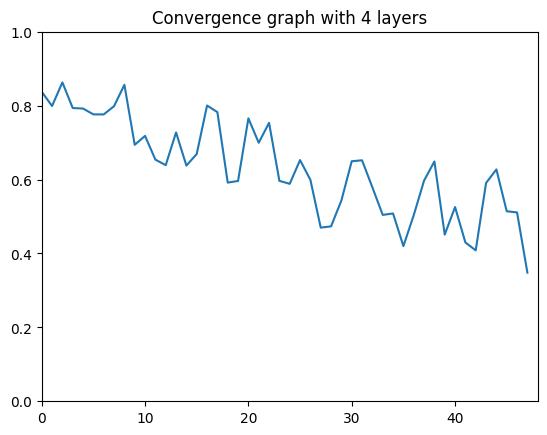

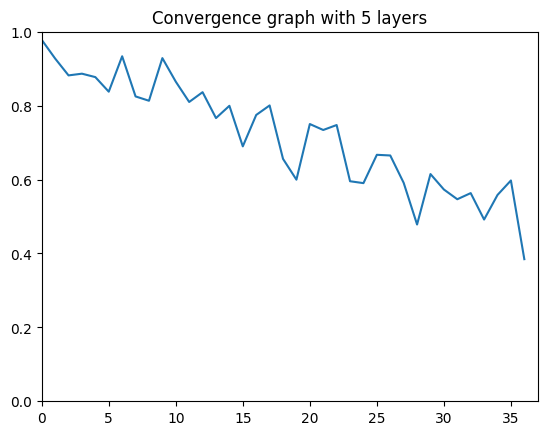

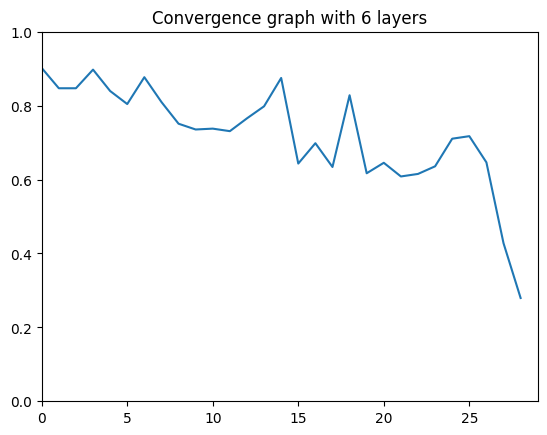

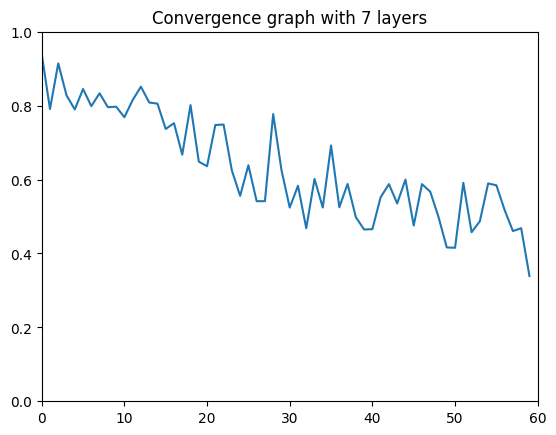

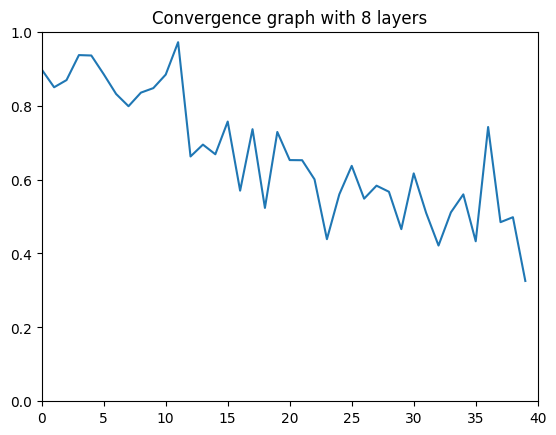

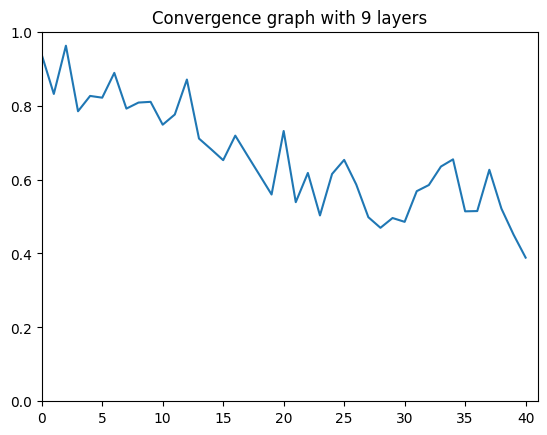

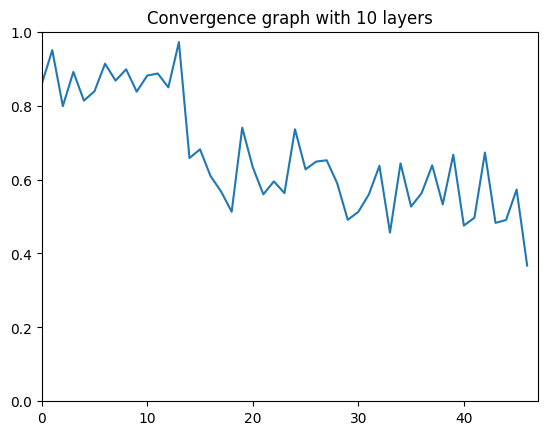

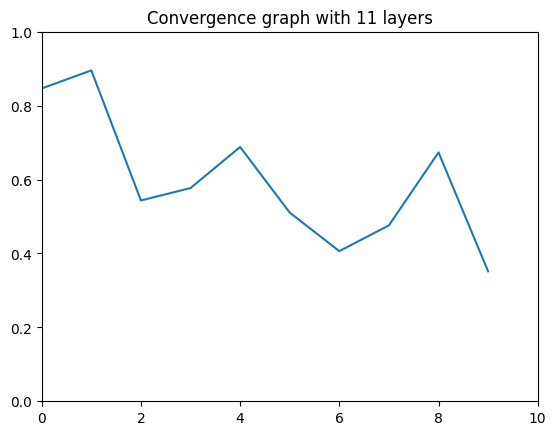

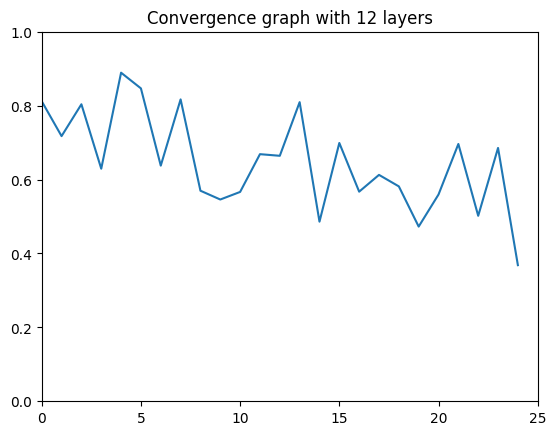

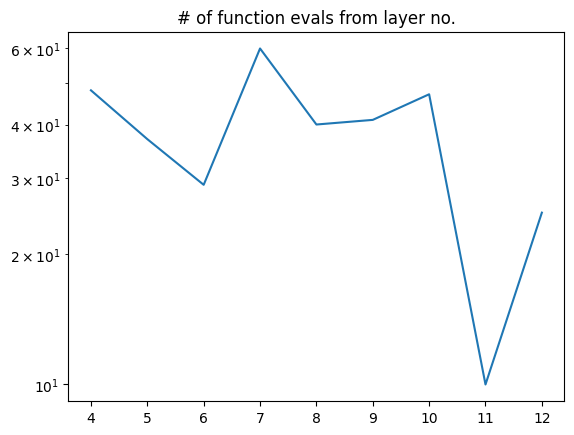

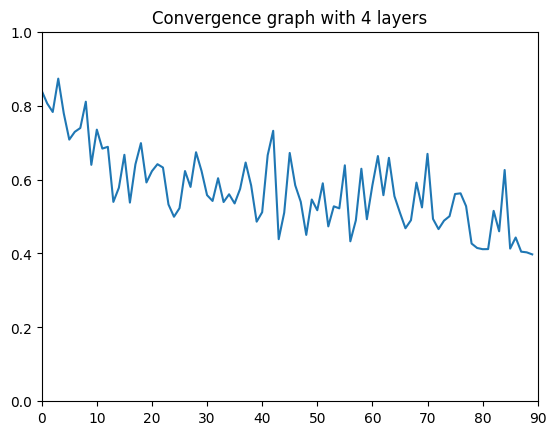

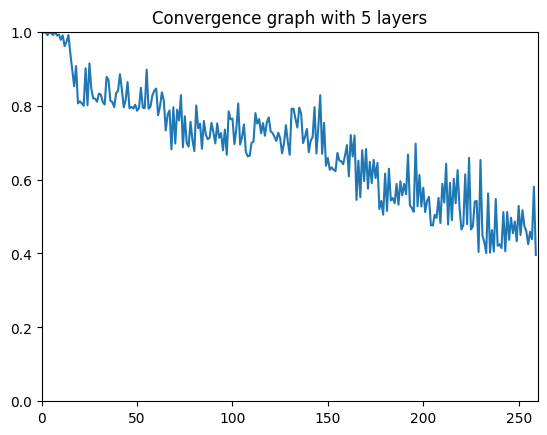

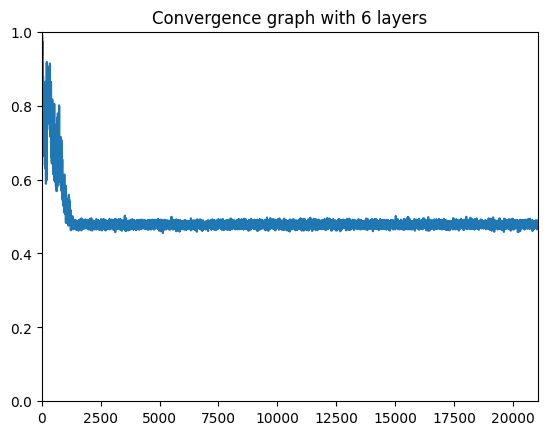

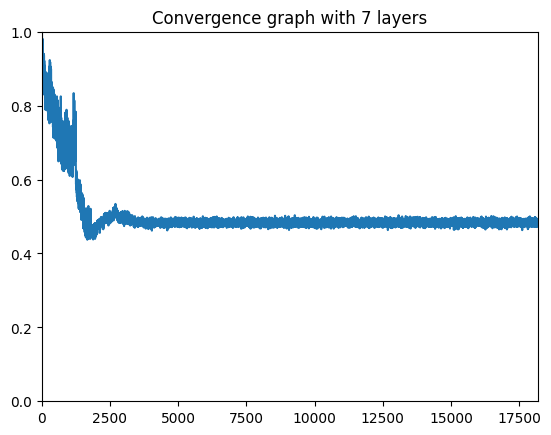

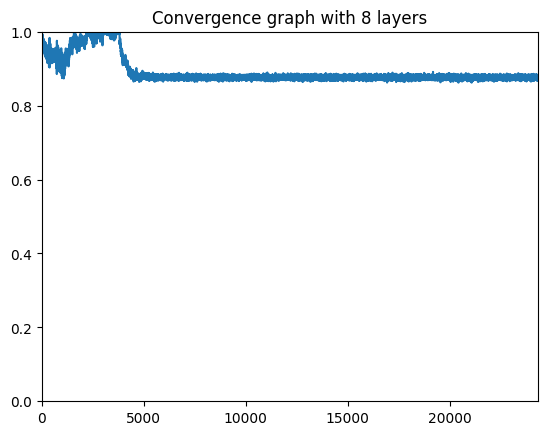

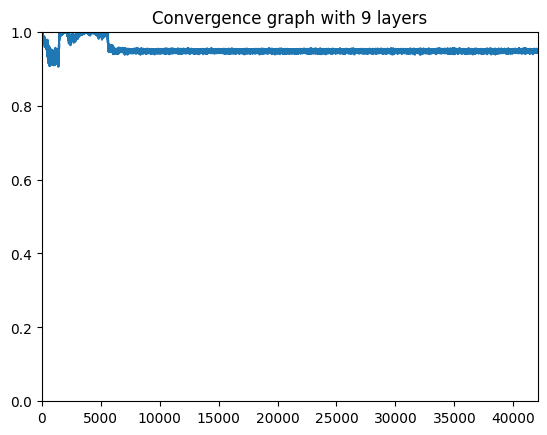

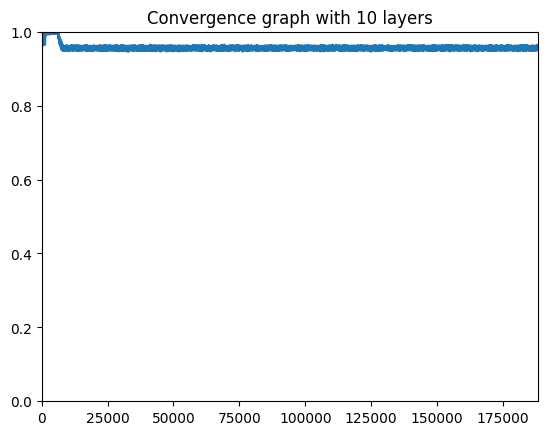

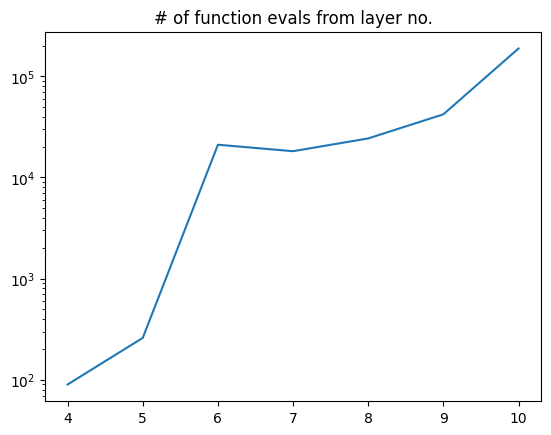

<Figure size 640x480 with 0 Axes>

In [10]:
stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_PATH)
graph_folder = os.path.join(os.getcwd(), VQC_FOLDER, NO_MUB_GRAPH_FOLDER)
no_mub_stats = gen_statistics_nomub(no_mub_res, stats_filename=stats_filename, graph_folder=graph_folder)

stats_filename = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_PATH)
graph_folder = os.path.join(os.getcwd(), VQC_FOLDER, N_QUBIT_NO_MUB_GRAPH_FOLDER)
n_qubit_no_mub_stats = gen_statistics_nomub(n_qubit_no_mub_res, stats_filename=stats_filename, graph_folder=graph_folder)

In [ ]:
plt.plot(n_qubit_no_mub_stats.keys(), [v['nfev'] for v in n_qubit_no_mub_stats.values()])
plt.show()

## Experimenting with MUBs - prepending
This is an experiment in which a MUB transformation is applied *before* the ansatz circuits.

### Default Experiment Values

In [26]:
optimizer = 'COBYLA'
success_bound = LO_CORR_THRESHOLD
tol = LO_TOL
K = 5
LAYERS = 7

### Loading the QASM MUB circuits into Qiskit

In [31]:
CIRC_FROM_FILES = True
if CIRC_FROM_FILES:
    paths = os.listdir(MUB_CIRC_3_PATH)
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths if '.txt' in path]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_file(os.path.join(MUB_CIRC_3_PATH,path)) for path in paths if '.txt' in path]
else:
    mub_circuits_2_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_2_302.values()]
    mub_circuits_3_qubits = [qk.circuit.QuantumCircuit.from_qasm_str(qasm_str) for qasm_str in qasm_3_306.values()]

### Experiment Functions

In [19]:
# This function gets a number i from 0 to (2^n)-1
# and returns a circuit that generates the state |i> when acting on |0>.
def get_comp_state_circ(state_idx: int, n_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    bin_str = bin(state_idx)[2:].zfill(n_qubits)
    for i, ch in enumerate(bin_str):
        if ch == '1':
            qc.x(i)
    return qc

comp_circuits = [get_comp_state_circ(i, N_QUBITS) for i in range(2 ** N_QUBITS)]

def run_vqc_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit,
                                 n_qubits: int, n_layers: int,
                                 theta0: List[float], tol: float = 0.2,
                                 success_bound: float = 0,
                                 optimizer: str = 'COBYLA',
                                 qi: QuantumInstance = qasm_qi) -> dict:
    mub_qc = mub_qc.copy()
    mub_qc.add_register(ClassicalRegister(n_qubits))
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        starting_qc.add_register(ClassicalRegister(n_qubits))
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqc_exp(full_qc, theta0, tol, success_bound, optimizer, qi)

    return res_dict


def run_vqc_exp_with_state_prepend(ansatz_qc: QuantumCircuit, state_qc: QuantumCircuit,
                                   n_qubits: int, theta0: List[float],
                                   tol: float = 0.2, success_bound: float=0,
                                   optimizer: str = 'COBYLA',
                                   qi: QuantumInstance = qasm_qi) -> dict:
    state_qc = state_qc.copy()
    state_qc.add_register(ClassicalRegister(n_qubits))
    full_qc = state_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert full_qc != None
    return run_vqc_exp(full_qc, theta0, tol, success_bound, optimizer, qi)

#### Experiments: try k random MUB states

In [20]:
def generate_k_mub_choices(k: int) -> List[Tuple[int, int]]:
    n_mubs = 2 ** N_QUBITS + 1
    n_states = 2 ** N_QUBITS
    assert k <= n_mubs * n_states
    res = []
    while k > 0:
        while True:
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (mub, state) not in res:
                res.append((mub, state))
                k -= 1
                break
    return res

In [33]:
# use qasm
optimizer = 'SLSQP'
print('=====Experimenting with SMALL SETS of prepended MUB states=====')
start_time = time.time()
first_time = start_time
curr_time = start_time
k_prepend_mub_results = {}
interrupted = False
# for n_layers in range(4,13):
for n_layers in [LAYERS]:
    if interrupted:
        break
    layer_results = {}
    print(f'---starting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = generate_k_mub_choices(K)
    
    for mub, state in state_choices:
        print(f'experimenting with MUB {mub}, state {state}')
        mub_qc: QuantumCircuit = mub_circuits_3_qubits[mub].copy()
        state_qc: QuantumCircuit = comp_circuits[state].copy()
        full_state_qc = state_qc.compose(mub_qc, inplace=False)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, N_QUBITS, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer)
        print(f'({mub},{state}) done')
        
        if state_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            break
        elif state_data[1] == True:
            state_data = (state_data[0], [])

        curr_time = time.time()
        print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = curr_time
        
        layer_results[(mub, state)] = state_data
        
    k_prepend_mub_results[n_layers] = layer_results
print(f'total took {curr_time - first_time} seconds')

=====Experimenting with SMALL SETS of prepended MUB states=====
---starting with 7 layers---
experimenting with MUB 5, state 7


/home/ittay.al/miniconda3/envs/qc/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


(5,7) done
Finished experiment in 61.34448766708374 seconds at Tue Sep 20 17:28:49 2022
experimenting with MUB 4, state 0
(4,0) done
Finished experiment in 49.912273645401 seconds at Tue Sep 20 17:29:39 2022
experimenting with MUB 2, state 7
(2,7) done
Finished experiment in 13.22501802444458 seconds at Tue Sep 20 17:29:52 2022
experimenting with MUB 0, state 7
(0,7) done
Finished experiment in 13.456552743911743 seconds at Tue Sep 20 17:30:05 2022
experimenting with MUB 7, state 5
(7,5) done
Finished experiment in 16.114275693893433 seconds at Tue Sep 20 17:30:21 2022


### Experiments: try k random parameters

In [8]:
print('=====Experimenting with SMALL SETS of radnom initial parameters=====')
random_thetas_results = {}
# for n_layers in range(4,13):
for n_layers in [LAYERS]:
    layer_results = []
    print(f'---experimenting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    
    for i in range(K):
        theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
        print(f'experimenting with random parameter set #{i}')
        exp_data = run_vqc_exp(ansatz, theta0, tol=HI_TOL)
        print(f'parameter set #{i} done')
        layer_results.append((theta0, exp_data))
        
    random_thetas_results[n_layers] = layer_results

=====Experimenting with SMALL SETS of radnom initial parameters=====
---experimenting with 4 layers---
experimenting with random parameter set #0
parameter set #0 done
---experimenting with 5 layers---
experimenting with random parameter set #0
parameter set #0 done
---experimenting with 6 layers---
experimenting with random parameter set #0
parameter set #0 done


### Experiments: Try k half-MUBs

In [ ]:
def gen_half_mub_circ(n_qubits: int, qubit_1: int, qubit_2: int, mub_no: int, state_no: int, mub_circuits: List[QuantumCircuit]) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    comp_state_qc = get_comp_state_circ(state_no, n_qubits=2)
    qc.compose(comp_state_ec, qubits=[qubit_1, qubit_2], inplace=True)
    qc.compose(mub_circuits[mub_no], qubits=[qubit_1, qubit_2], inplace=True)
    return qc

def gen_k_half_mub_choices(n_qubits: int, k: int) -> List[Tuple[int, int, int, int]]:
    n_mubs = 2 ** 2 + 1
    n_states = 2 ** 2
    # m mubs * (n choose 2) pairs of qubits
    assert k <= n_mubs * n_qubits * (n_qubits-1) // 2
    res = []
    while k > 0:
        while True:
            qubit_1 = randint(0, n_qubits-2)
            qubit_2 = randint(qubit_1+1, n_qubits-1)
            mub = randint(0, n_mubs-1)
            state = randint(0, n_states-1)
            if (mub, state) not in res:
                res.append((qubit_1, qubit_2, mub, state))
                k -= 1
                break
    return res

In [ ]:
# use qasm
# optimizer = 'SLSQP'
print('=====Experimenting with SMALL SETS of prepended half-MUB states=====')
start_time = time.time()
k_prepend_half_mub_results = {}
interrupted = False
# for n_layers in range(4,13):
for n_layers in [LAYERS]:
    if interrupted:
        break
    layer_results = {}
    print(f'---starting with {n_layers} layers---')
    ansatz = gen_vqc_ansatz_arrasmith(N_QUBITS, n_layers)
    theta0 = [rand_angle() for _ in range(ansatz.num_parameters)]
    state_choices = generate_k_half_mub_choices(K)
    
    for choice in state_choices:
        print(f'experimenting with pair {(choice[0], choice[1])}, MUB {choice[2]}, state {choice[3]}')
        full_state_qc = gen_half_mub_circ(N_QUBITS, *choice, mub_circuits_2_qubits)
        state_data = run_vqc_exp_with_state_prepend(ansatz, full_state_qc, N_QUBITS, theta0, tol=tol, success_bound=success_bound, optimizer=optimizer)
        print(f'{choice} done')
        
        if state_data[1] == False: # Signifying keyboard interrupt
            interrupted = True
            break
        elif state_data[1] == True:
            state_data = (state_data[0], [])

        curr_time = time.time()
        print(f'Finished experiment in {curr_time - start_time} seconds at {time.asctime(time.localtime())}')
        start_time = curr_time
        
        layer_results[(mub, state)] = state_data
        
    k_prepend_mub_results[n_layers] = layer_results

### Analysis Functions

In [14]:
# Analyze the performance of using MUB states as initial states for an ansatz
def gen_statistics_prepending(prepend_results_dict: Dict[int, Dict[Tuple[int, int], Tuple[List[float], VQEResult]]],
no_mub_stats: Dict[int, Dict[str, int]], corr_threshold: float = HI_CORR_THRESHOLD,
filename: str = PRE_MUB_PATH) -> Dict[int, Dict[str, any]]:

    prepend_stats = {}
    for l, d_l in prepend_results_dict.items():
        layer_stats = {}
        min_nfev = min([nfev(state_data) for state_data in d_l.values()])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(state_data) for state_data in d_l.values()])

        # # Experiments with smaller convergence time
        # adv_states = {state_idx: nfev(state_data) for state_idx, state_data in d_l.items() if nfev(state_data) < no_mub_stats[l]['nfev']}
        # layer_stats['adv_states'] = adv_states
        # layer_stats['adv_states_count'] = len(adv_states)
        # layer_stats['adv_addition_percent'] = len(adv_states) / len(d_l)
        # layer_stats['adv_avg_nfev'] = avg(adv_states.values())
            
            
        # Experiments that terminated closer to the intended result
        correct_states = {state: fin_val(state_data) for state_idx, state_data in d_l.items() if fin_val(state_data) < corr_threshold}        
        layer_stats['correct_states'] = correct_states
        layer_stats['correct_states_count'] = len(correct_states)
        layer_stats['correct_addition_percent'] = len(correct_states) / len(d_l)
        layer_stats['correct_avg_val'] = avg(correct_states.values())
        
        layer_stats['evals'] = {k: v[0] for k,v in d_l.items()}
        layer_stats['fin_vals'] = {k: fin_val(v) for k,v in d_l.items()}
        prepend_stats[l] = layer_stats

    with open(filename, 'w') as f:
        pprint(prepend_stats, f)

    return prepend_stats

def gen_statistics_random_thetas(random_thetas_results_dict: Dict[int, List[Tuple[List[float],Tuple[List[float], VQEResult]]]],
                            corr_threshold: float = HI_CORR_THRESHOLD, filename: str = RANDOM_THETAS_PATH_3) -> Dict[int, Dict[str, any]]:
    random_thetas_stats = {}
    for l, list_l in random_thetas_results.items():
        layer_stats = {}
        min_nfev = min([nfev(exp_data) for _, exp_data in list_l])
        layer_stats['min_nfev'] = min_nfev
        layer_stats['avg_nfev'] = avg([nfev(exp_data) for _, exp_data in list_l])
        correct_thetas = [fin_val(exp_data) for _, exp_data in list_l if fin_val(exp_data) < corr_threshold]
        layer_stats['correct_thetas_count'] = len(correct_thetas)
        layer_stats['correct_addition_percent'] = len(correct_thetas) / len(list_l)
        layer_stats['correct_avg_val'] = avg(correct_thetas)
        
        layer_stats['evals'] = {k: v[1][0] for k,v in enumerate(list_l)}
        layer_stats['fin_vals'] = {k: fin_val(v[1]) for k,v in enumerate(list_l)}
        random_thetas_stats[l] = layer_stats
        
    with open(filename, 'w') as f:
        pprint(random_thetas_stats, f)
    return random_thetas_stats


#### Analysis

In [15]:
# filename = os.path.join(os.getcwd(), VQC_FOLDER, K_PRE_MUB_PATH)
# k_prepend_stats = gen_statistics_prepending(k_prepend_mub_results, {}, filename=filename)

filename = os.path.join(os.getcwd(), VQC_FOLDER, RANDOM_THETAS_PATH_3)
k_random_stats = gen_statistics_random_thetas(random_thetas_results, corr_threshold=HI_CORR_THRESHOLD, filename=filename)

In [ ]:
for l, d_l in k_prepend_stats.items():
    for idx, evals in d_l['evals'].items():
        plt.axis([0, len(evals), 0, 1])
        plt.plot(evals)
        plt.title(f'Convergence graph with MUB state {idx} and {l} layers')
        plt.plot([0, len(evals)-1], [0.4, 0.4], color='red')
        plt.savefig(os.path.join(os.getcwd(), VQC_FOLDER, '3 qubit k mub graphs', f'{l},{idx[0]},{idx[1]}.png'))
        plt.show()
        # evals, result = data
        # plt.axis([0, len(evals), 0, 1])
        # plt.plot(evals)
        # plt.title(f'Convergence graph with {l} layers')
        
        # if target_vals != []:
        #     plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='red')
        # for fake_target in target_vals[1:]:
        #     plt.plot([0, len(evals)-1], [target_vals[0], target_vals[0]], color='purple')
            
        # plt.show()
        # plt.savefig(os.path.join(graph_folder, f'{l}.png'))

## Collective Experiments - VQC

### Plotting Functions

In [137]:
def myplot(data: dict, label: str):
    data = {k: v for k,v in data.items() if v != None}
    lists = sorted(data.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.plot(x, y, label=label, marker='o')

def myplot_heatmap(data: list, true_sol: float, false_sols: list = [], val_range=(-0.1, 0.7), bin_count=50, title=""):
    plt.hist(data, bin_count, range=val_range, color='blue')

    # Add Correct Result Line
    plt.plot([true_sol,true_sol], [0,10], color='green', linewidth=1)

    for val in false_sols:
        plt.plot([val, val], [0,10], color='red', linewidth=1)

    plt.title(title)
    plt.show()
    

### (Optionally) Load Data Fom Files

In [ ]:
from ast import literal_eval

STATS_FROM_FILES = True

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), VQC_FOLDER, name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)

### Raw Summary Data

In [ ]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)

In [ ]:
# plt.hist([layer['fin_val'] for layer in no_mub_stats.values()], 50, range=(-0.1, 0.5), density=True)
# plt.plot([0,0], [0,5])
# plt.title('final values without MUBS')
# plt.show()

# for layer, layer_stats in prepend_stats.items():
#     plt.hist(layer_stats['fin_vals'], 50, range=(-0.1, 0.5), density=True)

#     # Add Correct Result Line
#     plt.plot([0,0], [0,30], color='green', linewidth=1)
#     plt.title(f'function evaluations for {layer} layers')
#     plt.show()

myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], 0.0, title='final values without using MUBs', bin_count=50)
for layer, layer_stats in prepend_stats.items():
    myplot_heatmap(layer_stats['fin_vals'], 0.0, title=f'function evaluations for {layer} layers', bin_count=50)



### Minimal \# Of Function Evals

In [ ]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
plot_min_nfev(prepend_stats, "Prepended MUB states")
plot_min_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Average \# Of Function Evals

In [ ]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Percent of Advantageous Additions

In [ ]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

In [ ]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Summary: MUB Prepending

In [ ]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()

## Basic Barren Plateau Circuit for Transverse Ising VQE
To save myself some time, I'll just use the built-in VQE module.

In [108]:
def build_pauli_string(n_qubits: int, mat_locations: Dict[int, str]) -> str:
    assert n_qubits > 0
    H = ''
    for i in range(n_qubits):
        H += mat_locations.get(i, 'I')
    return H

def generate_transverse_ising_ham(n_qubits: int) -> PauliSumOp:
    # Build Individual X strings
    string_list = [(build_pauli_string(n_qubits, {i: 'X'}), random()) for i in range(n_qubits)]
    for i in range(n_qubits):
        string_list += [(build_pauli_string(n_qubits, {i: 'Z', j: 'Z'}), random()) for j in range(i+1, n_qubits)]
    return PauliSumOp.from_list(string_list, 1)

In [ ]:
# Note that the ansatz structure is identical, only that there is no basic measurement at the end.

def gen_vqe_ansatz_cerezo(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)

    idx = 0

    for i in range(n_qubits):
        theta = Parameter(f'theta_{idx}')
        idx += 1
        qc.ry(theta, i)
        

    for layer in range(n_layers):
        for i in range(0, n_qubits-1, 2):
            qc.cz(i, i+1)
        
        for i in range(n_qubits-1):
            theta1 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta1, i)

        for i in range(1, n_qubits-1, 2):
                qc.cz(i, i+1)
            
        for i in range(1, N_QUBITS):
            theta2 = Parameter(f'theta_{idx}')
            idx += 1
            qc.ry(theta2, i)

    return qc


def gen_vqe_ansatz_arrasmith(n_qubits: int, n_layers: int) -> QuantumCircuit:
    qc = qk.QuantumCircuit(n_qubits)
    count=1
    for _ in range(n_layers):
        
        # First layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        # First layer of even CXs
        for i in range(0, n_qubits-1, 2):
            qc.cx(i, i+1)
            
        # Second layer of U3 gates
        for i in range(n_qubits):
            thetas = [Parameter(f'theta_{count+z}') for z in range(3)]
            qc.u(*thetas, i)
            count += 3
            
        for i in range(1, n_qubits, 2):
            qc.cx(i, (i+1)%n_qubits)
            
    qc.measure_all()
        
    return qc


### Experimenting without MUBs

#### Experiment Functions

In [106]:
# Returns the number of function evaluations it took for the method to converge.
def run_vqe_exp(ansatz: QuantumCircuit, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = HI_TOL) -> Tuple[List[float], VQEResult]:
    cost_points = []
    
    def callback(nfev: int, params: np.ndarray, mean: float, std_dev: float):
        cost_points.append(mean)
        
    
    optimizer = COBYLA(maxiter=MAX_ITER, tol=tol)
    vqe = VQE(ansatz=ansatz, optimizer=optimizer, quantum_instance=qi, initial_point=np.asarray(theta0), callback=callback)
    result = vqe.compute_minimum_eigenvalue(operator=ham)
    return cost_points, result

#### Experiments

In [ ]:
no_mub_res_vqe = {}

for n_layers in range(4, 13):
    print(f'RUNNING VQE EXPERIMENT FOR {n_layers} LAYERS:')
    # n_qubits = n_layers
    ham = generate_transverse_ising_ham(N_QUBITS)
    ansatz = gen_hardware_eff_ansatz(N_QUBITS, n_layers)
#     theta0 = [(np.random.random()) * 2 * pi - pi for _ in range(ansatz.num_parameters)]
    theta0 = [0 for _ in range(ansatz.num_parameters)]
    layer_res = run_vqe_exp(ansatz, ham, theta0=theta0, tol=LO_TOL)
    no_mub_res_vqe[n_layers] = layer_res

In [110]:
eigen_values, eigen_vectors = np.linalg.eigh(ham.to_matrix())

In [67]:
exact_result = eigen_values[0]
print(f"The exact result is: {exact_result}")
print(f"The excited states are: {eigen_values[1:]}")

The exact result is: -2.611073908575124
The excited states are: [-1.75710396 -0.76553487 -0.13554306  0.18934452  0.5137937   1.90793569
  2.65818189]


#### Analysis

In [102]:
# calculate the error from the exact result
for i in range(4, 13):
    print("Error for layer number " + str(i) +": " + str(abs(no_mub_res_vqe[i].eigenvalue - exact_result)))

Error for layer number 4: 0.24741949013293674
Error for layer number 5: 0.42165700401507644
Error for layer number 6: 0.6261742020762586
Error for layer number 7: 0.4706022584405041
Error for layer number 8: 0.21401529415827358
Error for layer number 9: 1.1897460560061148
Error for layer number 10: 0.36511685386935877
Error for layer number 11: 0.055285308974512226
Error for layer number 12: 0.1638953533226779


In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', NO_MUB_PATH)
no_mub_stats = gen_statistics_nomub(no_mub_res_vqe, filename=filename)
print(no_mub_stats)
myplot_heatmap([layer['fin_val'] for layer in no_mub_stats.values()], exact_result, eigen_values[1:])


### Experimenting with MUBs - prepending (VQE)

#### Experiment Functions

In [140]:
def run_vqe_exp_with_mub_prepend(ansatz_qc: QuantumCircuit, mub_qc: QuantumCircuit, n_qubits: int, ham: PauliSumOp, theta0: Union[List[float], None] = None, tol: float = 0.2) -> dict:
    mub_qc = mub_qc.copy()
    mub_ansatz_qc = mub_qc.compose(ansatz_qc, qubits=range(n_qubits), inplace=False)
    assert mub_ansatz_qc != None

    res_dict = {}
    for i in range((2 ** n_qubits)):
        starting_qc = get_comp_state_circ(i, n_qubits)
        full_qc = starting_qc.compose(mub_ansatz_qc, qubits=range(n_qubits), inplace=False)
        assert full_qc != None
        res_dict[i] = run_vqe_exp(full_qc, ham, theta0=theta0, tol=tol)

    return res_dict

#### Experiments

In [ ]:
print('=====Experimenting with prepended MUB states=====')
ham = generate_transverse_ising_ham(N_QUBITS)
all_prepend_mub_results_vqe = {}

for n_layers in range(4,13):
    print(f'---experimenting with {n_layers} layers---')
    layer_results_vqe = {}
    ansatz = gen_hardware_eff_ansatz(N_QUBITS, n_layers)
    theta0 = [np.random.random() for _ in range(ansatz.num_parameters)]
    for i, mub_circuit in enumerate(mub_circuits_3_qubits):
        print(f'experimenting with MUB #{i+1}')
        res = run_vqe_exp_with_mub_prepend(ansatz, mub_circuit, N_QUBITS, ham, theta0=theta0, tol=LO_TOL)
        print(f'MUB #{i+1} done')
        layer_results_vqe[i] = res
    all_prepend_mub_results_vqe[n_layers] = layer_results_vqe

#### Analysis

In [ ]:
filename = os.path.join(os.getcwd(), 'VQE results', PRE_MUB_PATH)
prepend_stats = gen_statistics_prepending(all_prepend_mub_results_vqe, no_mub_stats, filename=filename)

### Note
I changed the random initial state for layers 4,5,12 and 6,7,8 and 9,10,11 to see that the result is changing drastically by the random choice

In [ ]:
for key in all_prepend_mub_results_vqe.keys():
    for key2 in all_prepend_mub_results_vqe[key].keys():
        for key3 in all_prepend_mub_results_vqe[key][key2].keys():
            print("num of layers: " + str(key), "MUB number: " + str(key2), "State number: " + str(key3), 
                  "eigenvalue: " + str(all_prepend_mub_results_vqe[key][key2][key3].eigenvalue))

## Collective Experiments - VQE

### (Optionally) Load Data Fom Files

In [97]:
from ast import literal_eval

STATS_FROM_FILES = False

def load_stats(name: str) -> dict:
    filename = os.path.join(os.getcwd(), 'VQE results', name)
    with open(filename, 'r') as f:
        data = f.read()
    
    return literal_eval(data)

if STATS_FROM_FILES:
    no_mub_stats = load_stats(NO_MUB_PATH)
    prepend_stats = load_stats(PRE_MUB_PATH)

### Raw Summary Data

In [ ]:
print('No MUBs:')
print(no_mub_stats)
print('Prepended MUB states:')
print(prepend_stats)

### Minimal \# Of Function Evals

In [ ]:
def plot_min_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    for v in stats_dict.values():
        assert 'min_nfev' in v.keys() or 'nfev' in v.keys()
    nfev_dict = {k: v['min_nfev'] if 'min_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Minimal # of Function Evals per layer')
plot_min_nfev(no_mub_stats, "No MUBs")
plot_min_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals

In [ ]:
def plot_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    avg_nfev_dict = {k: v['avg_nfev'] if 'avg_nfev' in v.keys() else v['nfev'] for k,v in stats_dict.items()}
    myplot(avg_nfev_dict, label)

plt.xlabel("# Layers")
plt.ylabel("Function Evals")
plt.title('Average # of Function Evals per layer')
plot_avg_nfev(no_mub_stats, "No MUBs")
plot_avg_nfev(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Percent of Advantageous Additions

In [ ]:
def plot_adv_percent(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_addition_percent'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Fraction of Advantageous Additions')
plt.title('Fraction of Advantageous Additions')
plot_adv_percent(prepend_stats, "Prepended MUB states")
plt.legend()
plt.show()

### Average \# Of Function Evals in Advantageous Additions

In [ ]:
def plot_adv_avg_nfev(stats_dict: Dict[int, Dict[str, any]], label: str):
    adv_percent_dict = {k: v['adv_avg_nfev'] for k,v in stats_dict.items()}
    myplot(adv_percent_dict, label)
    
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Average Function Evals for advantageous additions')
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_adv_avg_nfev(prepend_stats, "Prepended MUB states")
plot_adv_avg_nfev(append_stats, "Appended MUB trans.")
plt.legend()
plt.show()

### Summary: MUB Prepending

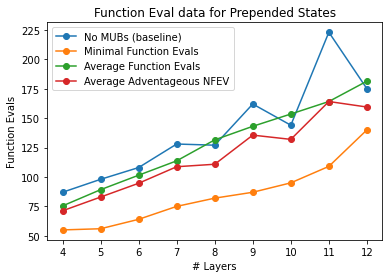

In [29]:
plot_min_nfev(no_mub_stats, "No MUBs (baseline)")
plot_min_nfev(prepend_stats, 'Minimal Function Evals')
plot_avg_nfev(prepend_stats, 'Average Function Evals')
plot_adv_avg_nfev(prepend_stats, 'Average Adventageous NFEV')
plt.xlabel("# Layers")
plt.ylabel('Function Evals')
plt.title('Function Eval data for Prepended States')
plt.legend()
plt.show()